# Auto-Interpretability Analysis

### Setup

In [188]:
import os
import json
import numpy as np
import pandas as pd

from group_sae.utils import load_training_clusters, load_cluster_map, MODEL_MAP

FUZZ_DIR = "results/fuzzing"
DETECT_DIR = "results/detection"

In [213]:
def extract_latent(file_name: str):
    file_name = file_name.split(".txt")[0]
    layer, latent = file_name.split("_latent")
    layer = layer.split(".")[-1]
    return int(latent), int(layer)


def load_cluster_results(size, cluster_id, what="fuzzing", warnings=True):
    cluster_map = load_training_clusters(size)
    layers = cluster_map[cluster_id]
    G = int(cluster_id.split("-")[0][1:])

    if what == "fuzzing":
        path = os.path.join(FUZZ_DIR, f"pythia-{size.lower()}/{G}")
    elif what == "detection":
        path = os.path.join(DETECT_DIR, f"pythia-{size.lower()}/{G}")
    else:
        raise ValueError("what must be either 'fuzzing' or 'detection'")

    def extract_latent(file_name: str):
        file_name = file_name.split(".txt")[0]
        layer, latent = file_name.split("_latent")
        layer = layer.split(".")[-1]
        return int(latent), int(layer)

    def spot_nans(x):
        if any([i is None for i in x]) and warnings:
            print(f"Found None in {file_name}")
        return [i for i in x if i is not None]

    results = {"latent": [], "layer": [], "correct": []}

    for file_name in os.listdir(path):
        latent, layer = extract_latent(file_name)

        if str(layer) in layers:
            with open(os.path.join(path, file_name), "r") as f:
                data = json.load(f)

            corrects = spot_nans([prompt["correct"] for prompt in data])

            results["latent"].append(latent)
            results["layer"].append(layer)
            results["correct"].append(np.mean(corrects) * 100)

    results = pd.DataFrame(results)
    results["cluster_id"] = cluster_id
    results["size"] = size
    return results


def load_baseline_results(size, what="fuzzing", warnings=True):

    if what == "fuzzing":
        path = os.path.join(FUZZ_DIR, f"pythia-{size.lower()}/baseline")
    elif what == "detection":
        path = os.path.join(DETECT_DIR, f"pythia-{size.lower()}/baseline")
    else:
        raise ValueError("what must be either 'fuzzing' or 'detection'")

    def spot_nans(x):
        if any([i is None for i in x]) and warnings:
            print(f"Found None in {file_name}")
        return [i for i in x if i is not None]

    results = {"latent": [], "layer": [], "correct": []}

    for file_name in os.listdir(path):
        latent, layer = extract_latent(file_name)

        with open(os.path.join(path, file_name), "r") as f:
            data = json.load(f)

        corrects = spot_nans([prompt["correct"] for prompt in data])

        results["latent"].append(latent)
        results["layer"].append(layer)
        results["correct"].append(np.mean(corrects) * 100)

    results = pd.DataFrame(results)
    results["cluster_id"] = results["layer"].apply(lambda x: f"layers.{x}")
    results["size"] = size
    return results


def load_results(size, what="fuzzing", warnings=True):
    training_clusters = load_training_clusters(size)
    all_results = [
        load_cluster_results(size, cluster_id, what, warnings)
        for cluster_id in training_clusters.keys()
    ]
    all_results.append(load_baseline_results(size, what, warnings))
    return pd.concat(all_results)


def load_and_map_results(size, what="fuzzing", warnings=True):
    results = load_results(size, what, warnings)
    summ_results = results.groupby(["size", "cluster_id", "layer"])["correct"].mean().reset_index()

    cluster_map = load_cluster_map(size)
    n_layers = MODEL_MAP[f"pythia-{size.lower()}"]["n_layers"]

    empty_results = pd.DataFrame(
        {
            "G": np.arange(1, n_layers).repeat(n_layers - 1),
            "cluster_id": [item for sublist in cluster_map.values() for item in sublist]
            + [f"layers.{i}" for i in range(n_layers - 1)],
            "layer": np.tile(np.arange(n_layers - 1), n_layers - 1),
        }
    )
    empty_results["G"] = empty_results["G"].astype(str).apply(lambda x: "B" if x == str(n_layers - 1) else x)
    return pd.merge(empty_results, summ_results, on=["cluster_id", "layer"], how="left")

In [214]:
fuzz_df = pd.concat([
    load_and_map_results("160m", "fuzzing", warnings=False),
    load_and_map_results("410m", "fuzzing", warnings=False),
    load_and_map_results("1b", "fuzzing", warnings=False),
])

detect_df = pd.concat([
    load_and_map_results("160m", "detection", warnings=False),
    load_and_map_results("410m", "detection", warnings=False),
    load_and_map_results("1b", "detection", warnings=False),
])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype

In [225]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
#from group_sae.utils import palette

suptitle_fontsize = 16
title_fontsize = 16
label_fontsize = 14
tick_fontsize = 10
annot_fontsize = 7

label_pad = 8
title_pad = 10

palette = ["#F7C485", "#F4B279", "#EB7E80"]

def plot_fuzz_detect(size, save=False):
    # Create a figure with 2 subplots in a 1x2 layout
    fig, ax = plt.subplots(1, 2, figsize=(12, 4.5), dpi=150, layout="tight")

    # Get the cluster IDs for the specific k value

    n_layers = MODEL_MAP[f"pythia-{size.lower()}"]["n_layers"]
    fuzz_subdf = fuzz_df[fuzz_df["size"] == size]
    detect_subdf = detect_df[detect_df["size"] == size]

    # Generate the expanded palette by interpolating between the base colors
    expanded_palette = sns.blend_palette(palette, n_colors=n_layers - 2)
    expanded_palette.append("#ced4da")

    for i, (eval_df, what) in enumerate(zip([fuzz_subdf, detect_subdf], ["fuzzing", "detection"])):
        sns.barplot(
            data=eval_df,
            x="G",
            hue="G",
            y="correct",
            ax=ax[i],
            zorder=2,
            palette=expanded_palette,
            legend=False,
        )

        #baseline_value = eval_df.loc[eval_df["G"] == "B", "correct"].iloc[0]
        #for j, patch in enumerate(ax[i].patches):
            # current_label = eval_df.loc[j, "G"]
            # current_value = patch.get_height()
            # # Calculate the delta percentage with respect to the baseline.
            # delta_pct = (current_value - baseline_value) / baseline_value * 100

            # For the baseline bar you may simply show "0%"; for others, include a '+' sign if nonnegative.
            # text = "0%" if current_label == "B" else f"{'+' if delta_pct >= 0 else ''}{delta_pct:.1f}%"

            # Position the text: center of the bar horizontally, and just above the bar.
            # x = patch.get_x() + patch.get_width() / 2.
            # y = current_value # add something
            # ax[i].text(x, y, text, ha="center", va="bottom", fontsize=annot_fontsize)

        ylims = (45, 55)
        ax[i].set_title(what.capitalize(), pad=title_pad, fontsize=label_fontsize)
        ax[i].set_ylim(ylims)
        ax[i].set_xlabel("G", labelpad=label_pad, fontsize=label_fontsize)
        ax[i].set_ylabel("")
        ax[i].tick_params(axis="x", labelsize=tick_fontsize)
        ax[i].tick_params(axis="y", labelsize=tick_fontsize)
        ax[i].grid(color="#adb5bd", linestyle="--", linewidth=0.5)

        # For the right plot, add a plus sign and percent symbol to the y-tick labels
        ax[i].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.0f}%"))

    plt.suptitle(f"Pythia {size}", fontsize=suptitle_fontsize)
    plt.subplots_adjust(hspace=0.4)

    if save:
        plt.savefig(f"imgs/avg_recon_{size}.svg", dpi=300, bbox_inches="tight")

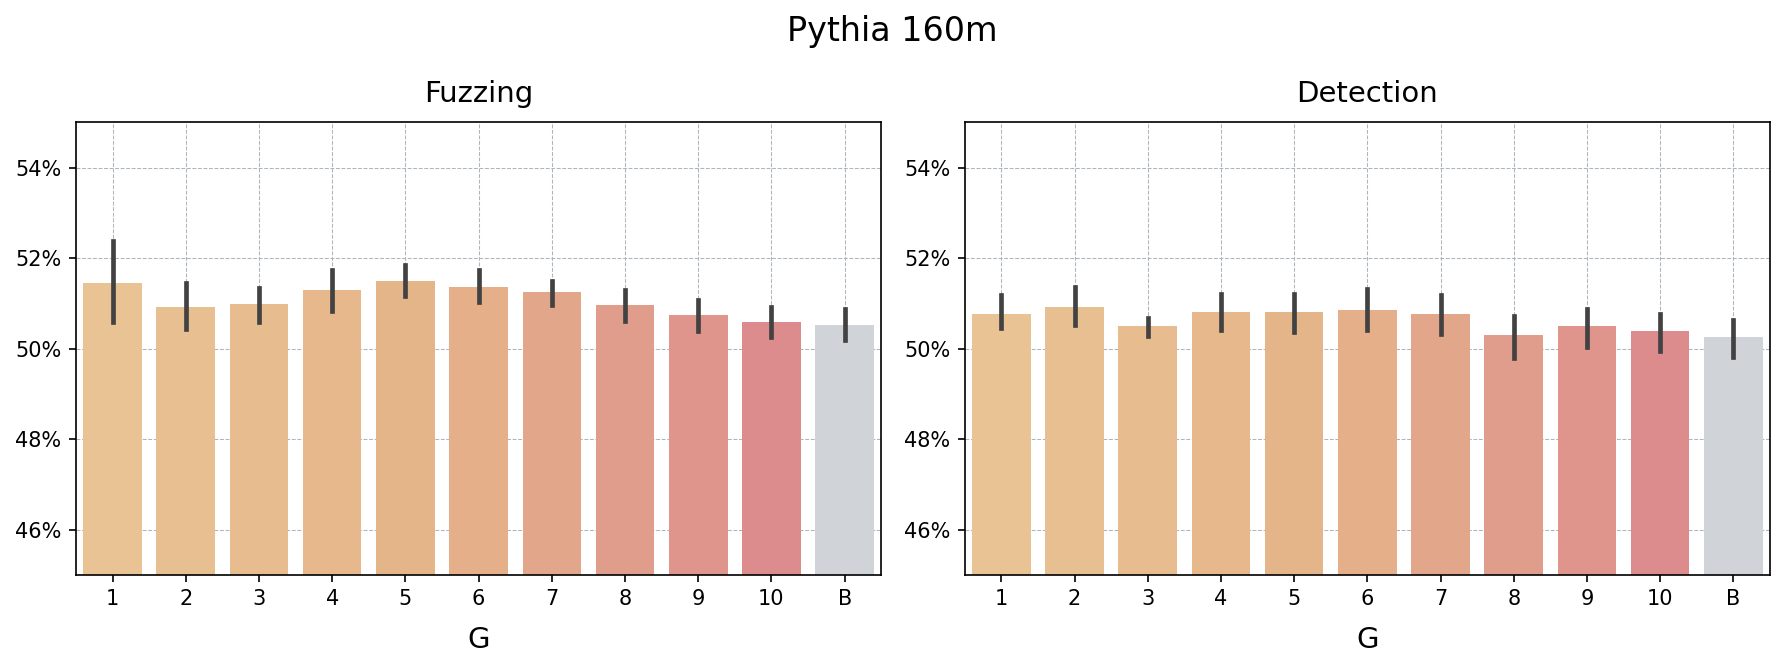

In [226]:
plot_fuzz_detect("160m", save=True)

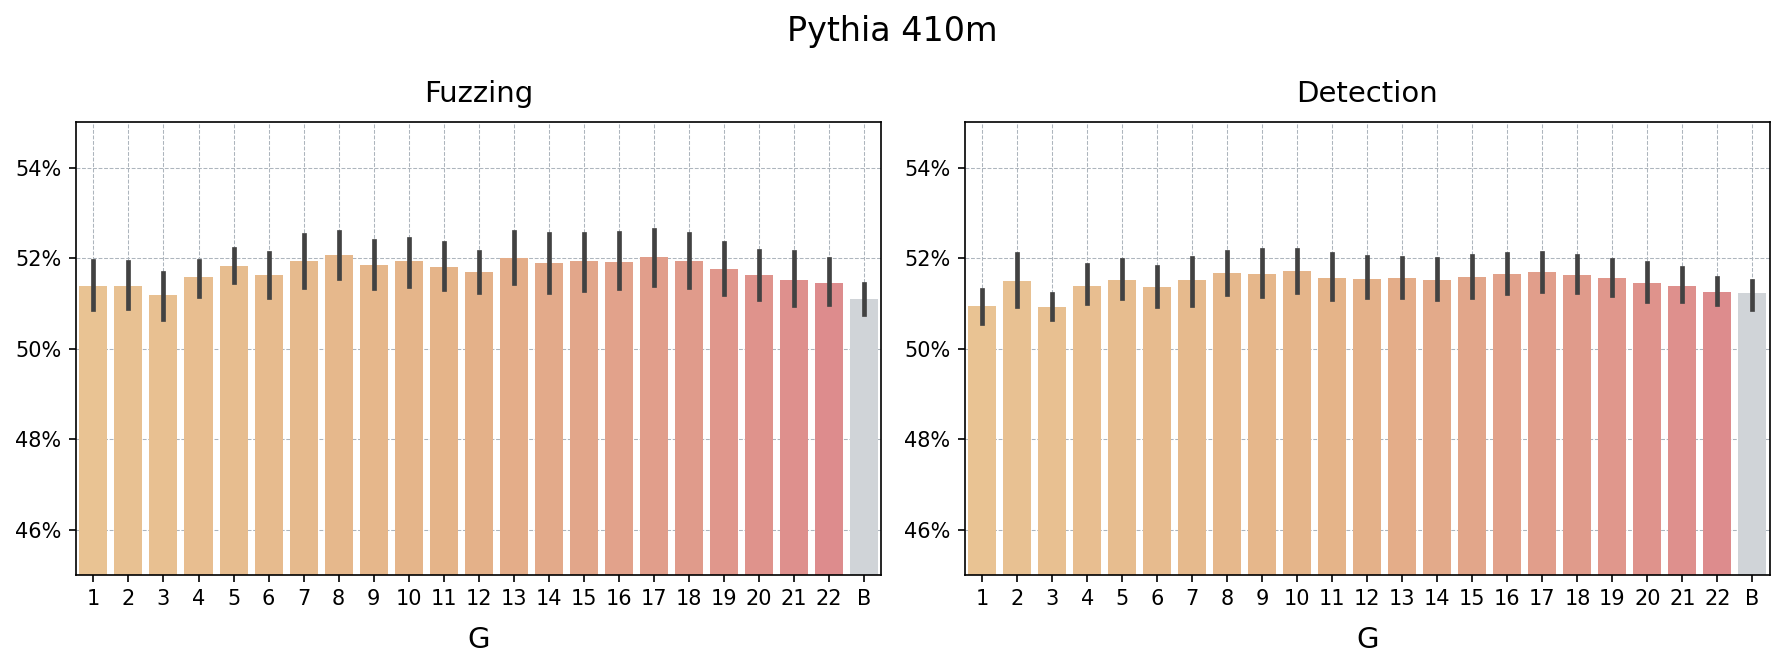

In [227]:
plot_fuzz_detect("410m", save=True)

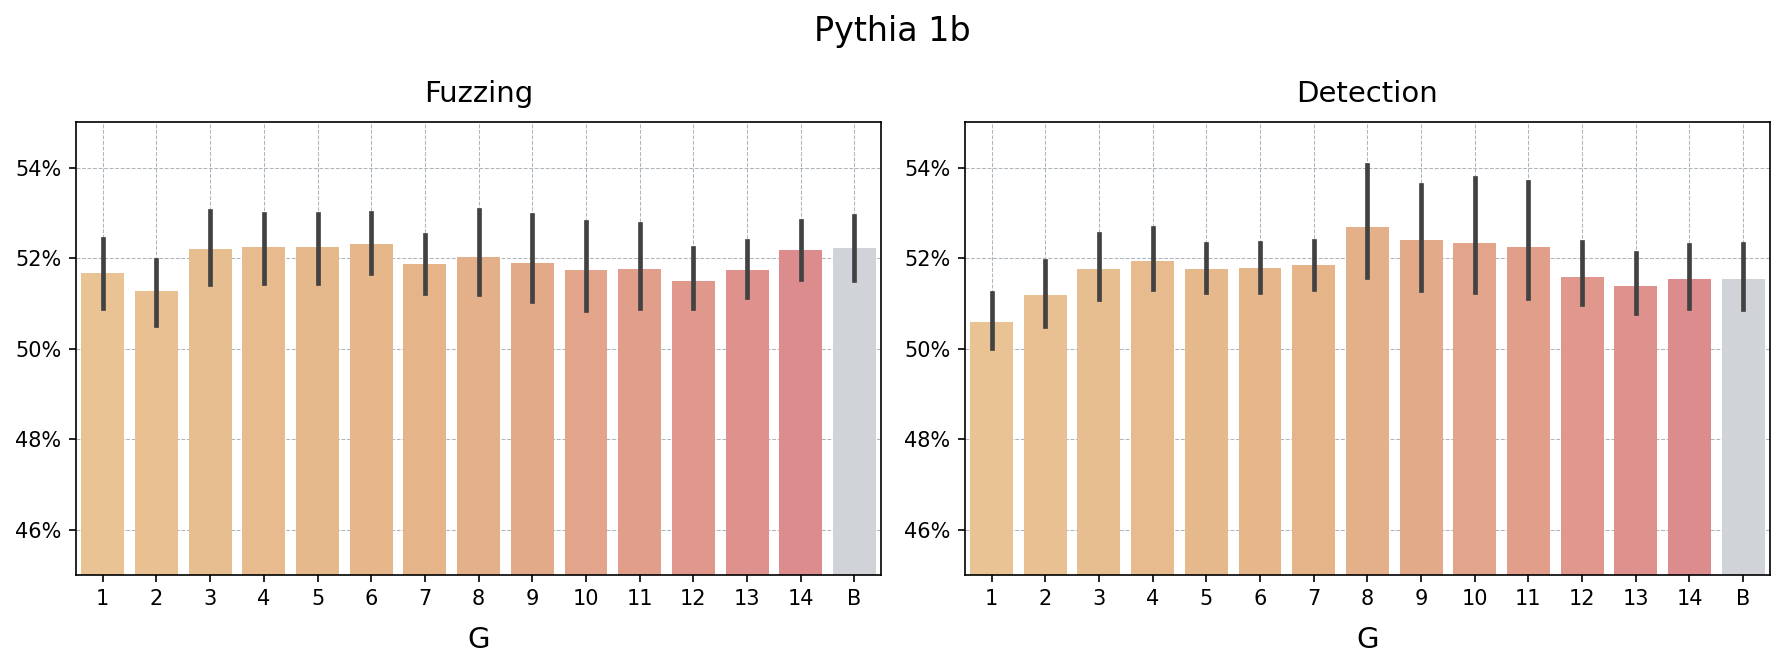

In [228]:
plot_fuzz_detect("1b", save=True)